In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as tdist
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt
from zlib import crc32

from code.baesan_neural_network import BayesanNeuralNetwork

In [3]:
theory = crc32('Никитин'.lower().encode('utf-8'))%3+1
practice = crc32('Nikitin'.lower().encode('utf-8'))%3+1
print(theory, practice)

3 2


In [4]:
def generate_dataset(p_mean, p_var_class, n_sample_per_class=5000, n_feaures=10):
    data_0 = np.random.normal(p_mean[0], p_var_class[0], n_sample_per_class*n_feaures)
    data_1 = np.random.normal(p_mean[1], p_var_class[1], n_sample_per_class*n_feaures)
    target = [0]*n_sample_per_class + [1]*n_sample_per_class
    data = np.r_[data_0, data_1]
    data = data.reshape(2*n_sample_per_class, n_feaures)
    return torch.Tensor(np.array(data)), torch.Tensor(np.array(target))

In [5]:
class Net(nn.Module):
    def __init__(self, in_feats=[10, 10], out_feats=[10, 10]):
        super(Net, self).__init__()
        layers = []
        for in_feat, out_feat in zip(in_feats, out_feats):
            layers.append(nn.Linear(in_feat, out_feat))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(out_feats[-1], 1))
        layers.append(nn.LogSigmoid())
        self.model  = nn.Sequential(*layers)
        
        
    def forward(self, x):
        return self.model(x)

In [6]:
var_model = BayesanNeuralNetwork(Net())

In [10]:
p_mean_class = [0., 4.]
p_var_class = [1., 1.]
train_data, train_target =  generate_dataset(p_mean_class, p_var_class, n_sample_per_class=100)
train_dataset = TensorDataset(train_data, train_target)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_data, test_target =  generate_dataset(p_mean_class, p_var_class, n_sample_per_class=100)
test_dataset = TensorDataset(test_data, test_target)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)

In [11]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.01)
standart_losses = []
test_acc = []
model.train()
for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data, target.float()
    optimizer.zero_grad()
    output = model(data)
    loss_error = F.binary_cross_entropy_with_logits(output[:, 0], target)
    loss = loss_error
    loss.backward()
    optimizer.step()
    standart_losses.append(float(loss))
    with torch.no_grad():
        n_correct = 0
        n_total = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data, target.float()
            optimizer.zero_grad()
            output = (torch.exp(model(data))[:, 0] > .5).float()
            n_correct += (output == target).float().sum()
            n_total += len(output)

        test_acc.append(n_correct/n_total)

In [12]:
optimizer = optim.Adam(var_model.parameters(), lr=0.01)
baysan_losses = []
bayesan_test_acc = []
var_model.train()
for batch_idx, (data, target) in enumerate(train_loader):
    data, target = Variable(data), Variable(target)
    data, target = data, target.float()
    optimizer.zero_grad()
    output = var_model(data)
    loss_error = F.binary_cross_entropy_with_logits(output[:, 0], target)
    loss_prior = var_model.prior_loss()
    loss = loss_error + loss_prior
    loss.backward()
    optimizer.step()
    baysan_losses.append((float(loss_error), float(loss_prior)))
    with torch.no_grad():
        n_correct = 0
        n_total = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data, target.float()
            optimizer.zero_grad()
            output = (torch.exp(model(data))[:, 0] > .5).float()
            n_correct += (output == target).float().sum()
            n_total += len(output)
        bayesan_test_acc.append(n_correct/n_total)

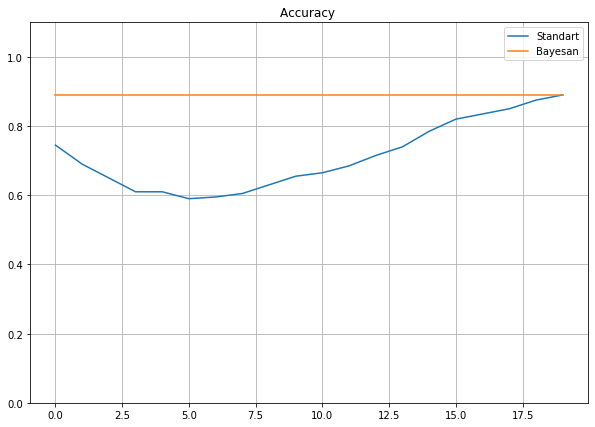

In [13]:
plt.figure(figsize=(10, 7))
plt.title('Accuracy ')
plt.grid()
plt.plot(test_acc, label='Standart')
plt.plot(bayesan_test_acc, label='Bayesan')
plt.ylim(0, 1.1)
plt.legend()

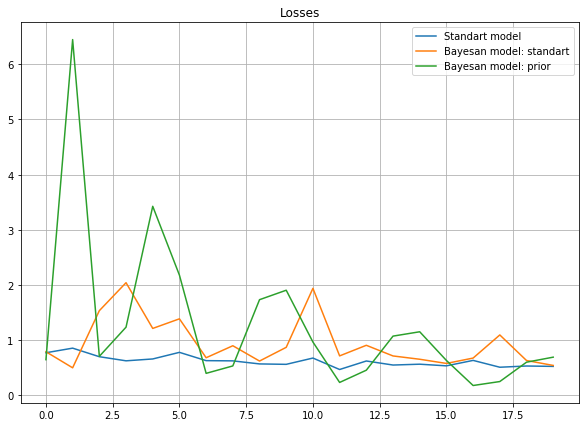

In [15]:
plt.figure(figsize=(10, 7))
plt.title('Losses')
plt.grid()
plt.plot(standart_losses, label='Standart model')
plt.plot([i[0] for i in baysan_losses], label='Bayesan model: standart')
plt.plot([i[1] for i in baysan_losses], label='Bayesan model: prior')
plt.legend()
plt.show()

* Реализован интерфейс для баесовского вывода 
* Реализовано решение простейшей задачи классификации с помощью данного интерфейса